In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
results = pd.read_csv('data/results.csv')
drivers = pd.read_csv('data/drivers.csv')
constructors = pd.read_csv('/dataconstructors.csv')

Ile razy kierowca jechał dla danego zespołu.

In [3]:
driver_constructor_counts = results.groupby(['driverId', 'constructorId']).size().reset_index(name='weight')

In [4]:
drivers['name'] = drivers['forename'] + ' ' + drivers['surname']
driver_id_to_name = dict(zip(drivers['driverId'], drivers['name']))
constructor_id_to_name = dict(zip(constructors['constructorId'], constructors['name']))

In [5]:
B = nx.Graph()

Kierowcy (bipartite = 0)

In [6]:
for driver_id in driver_constructor_counts['driverId'].unique():
    B.add_node(f'd_{driver_id}', 
               label=driver_id_to_name.get(driver_id, f'Driver {driver_id}'), 
               bipartite=0)

Zespoły (bipartite = 1)

In [7]:
for constructor_id in driver_constructor_counts['constructorId'].unique():
    B.add_node(f'c_{constructor_id}', 
               label=constructor_id_to_name.get(constructor_id, f'Team {constructor_id}'), 
               bipartite=1)

In [8]:
for _, row in driver_constructor_counts.iterrows():
    B.add_edge(f'd_{row["driverId"]}', f'c_{row["constructorId"]}', weight=row['weight'])

In [9]:
edges_data = [{
    'driver_id': row['driverId'],
    'driver_name': driver_id_to_name.get(row['driverId'], ''),
    'constructor_id': row['constructorId'],
    'constructor_name': constructor_id_to_name.get(row['constructorId'], ''),
    'weight': row['weight']
} for _, row in driver_constructor_counts.iterrows()]

In [10]:
edges_df = pd.DataFrame(edges_data)
edges_df.to_csv('driver_team_edges.csv', index=False)

Zapis do formatu graphml

In [25]:
nx.write_graphml(B, 'driver_team_graph.graphml')

Wizualizacja grafu

/tmp/ipykernel_10958/2503068484.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


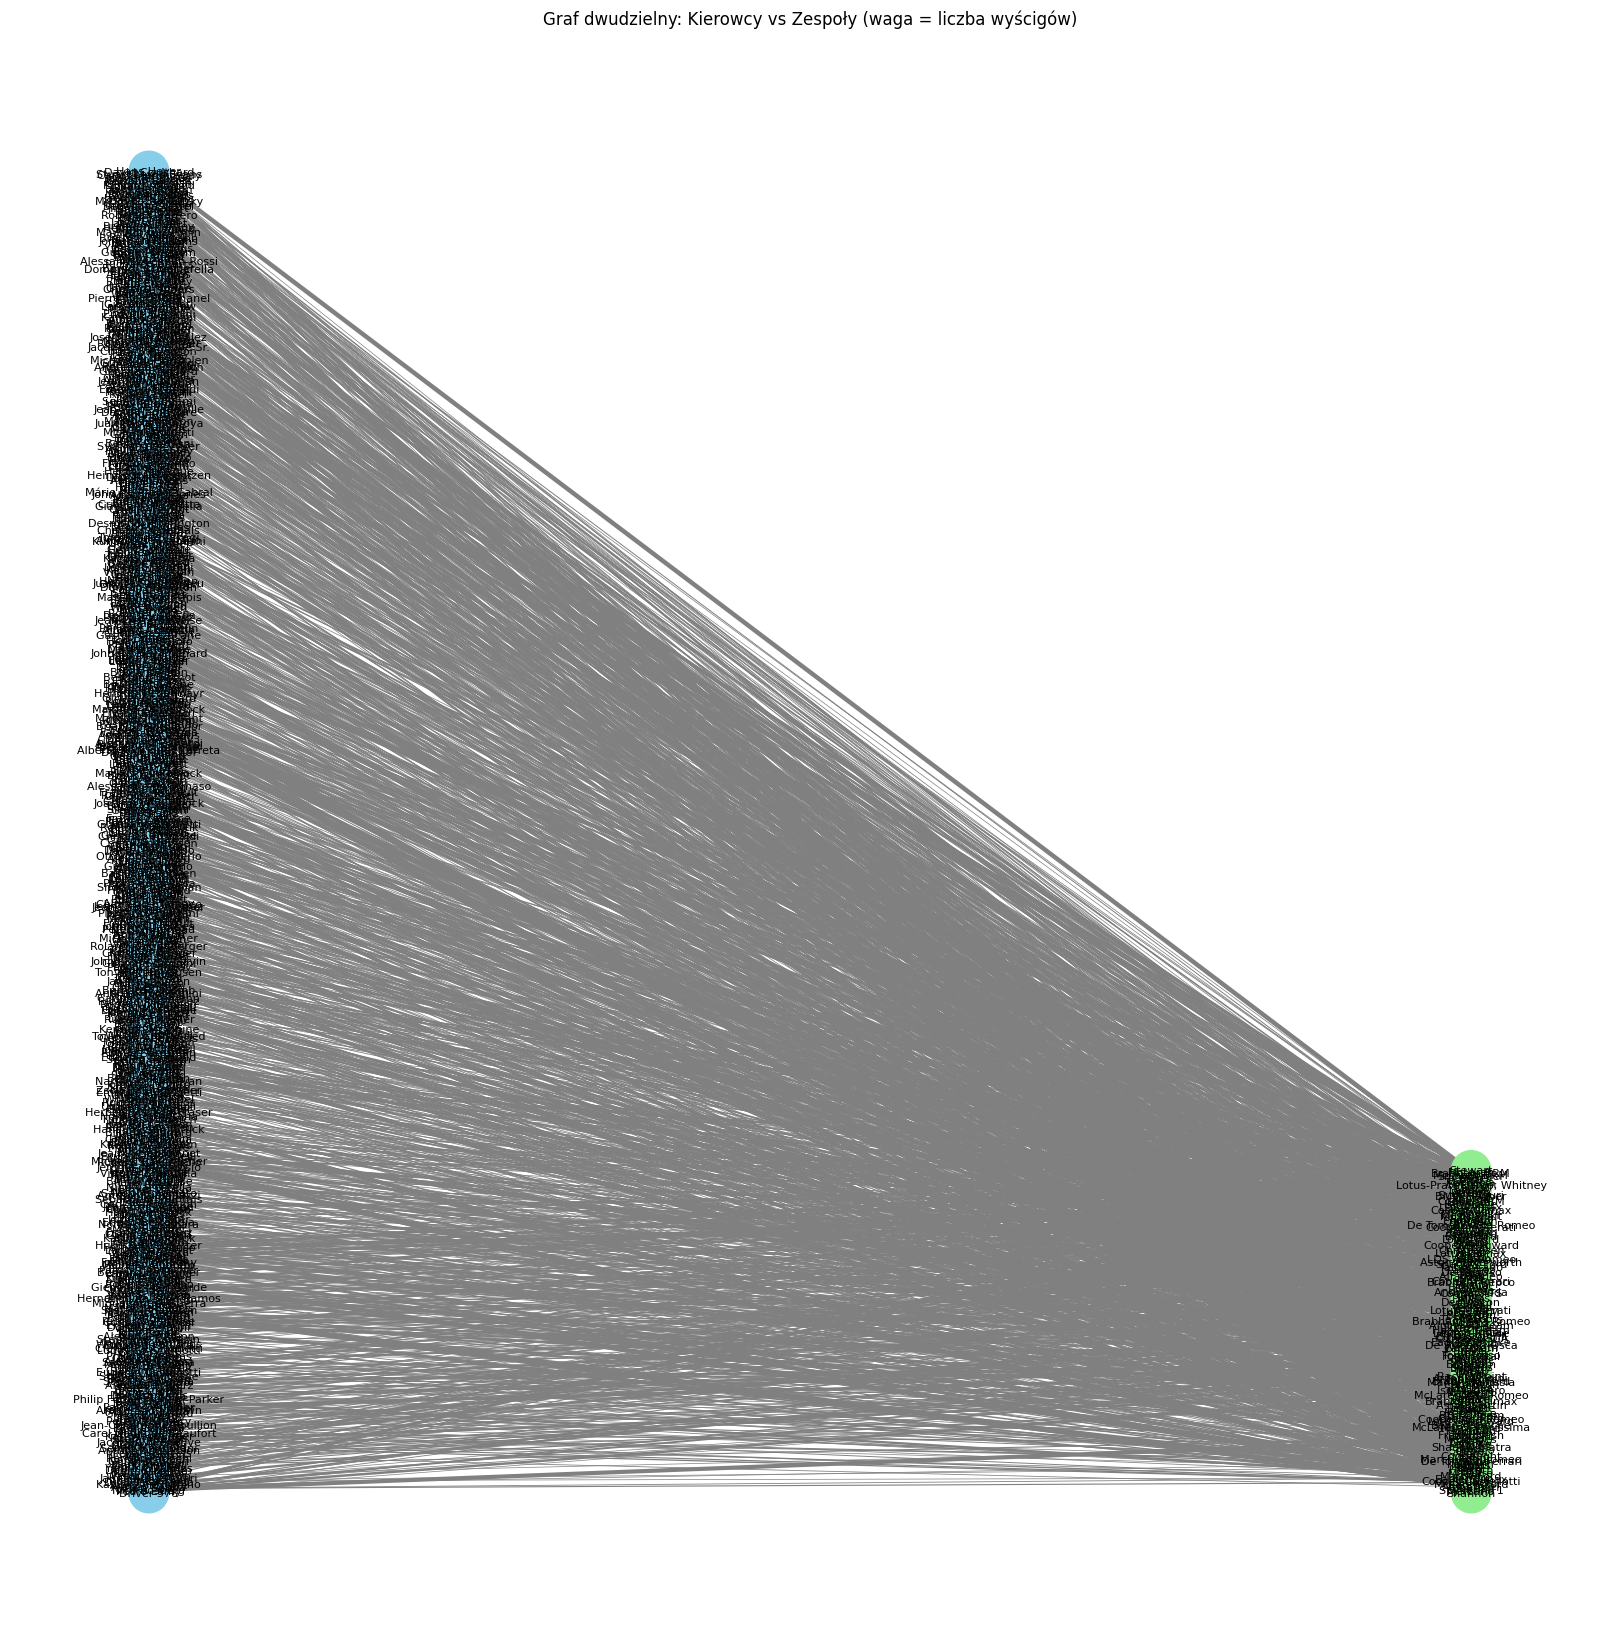

In [23]:
drivers_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
teams_nodes = set(B) - drivers_nodes

pos = dict()
pos.update((node, (1, i)) for i, node in enumerate(drivers_nodes))  # lewa strona
pos.update((node, (2, i)) for i, node in enumerate(teams_nodes))    # prawa strona

weights = [d['weight'] for _, _, d in B.edges(data=True)]
min_w = min(weights)
max_w = max(weights)

edge_weights = [0.5 + 4.5 * (w - min_w) / (max_w - min_w) for w in weights]

plt.figure(figsize=(16, 16))
nx.draw(
    B, pos,
    with_labels=True,
    labels=nx.get_node_attributes(B, 'label'),
    node_color=['skyblue' if n in drivers_nodes else 'lightgreen' for n in B.nodes()],
    edge_color='gray',
    node_size=800,
    width=edge_weights,
    font_size=8
)
plt.title("Graf dwudzielny: Kierowcy vs Zespoły (waga = liczba wyścigów)")
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_10958/1911693499.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


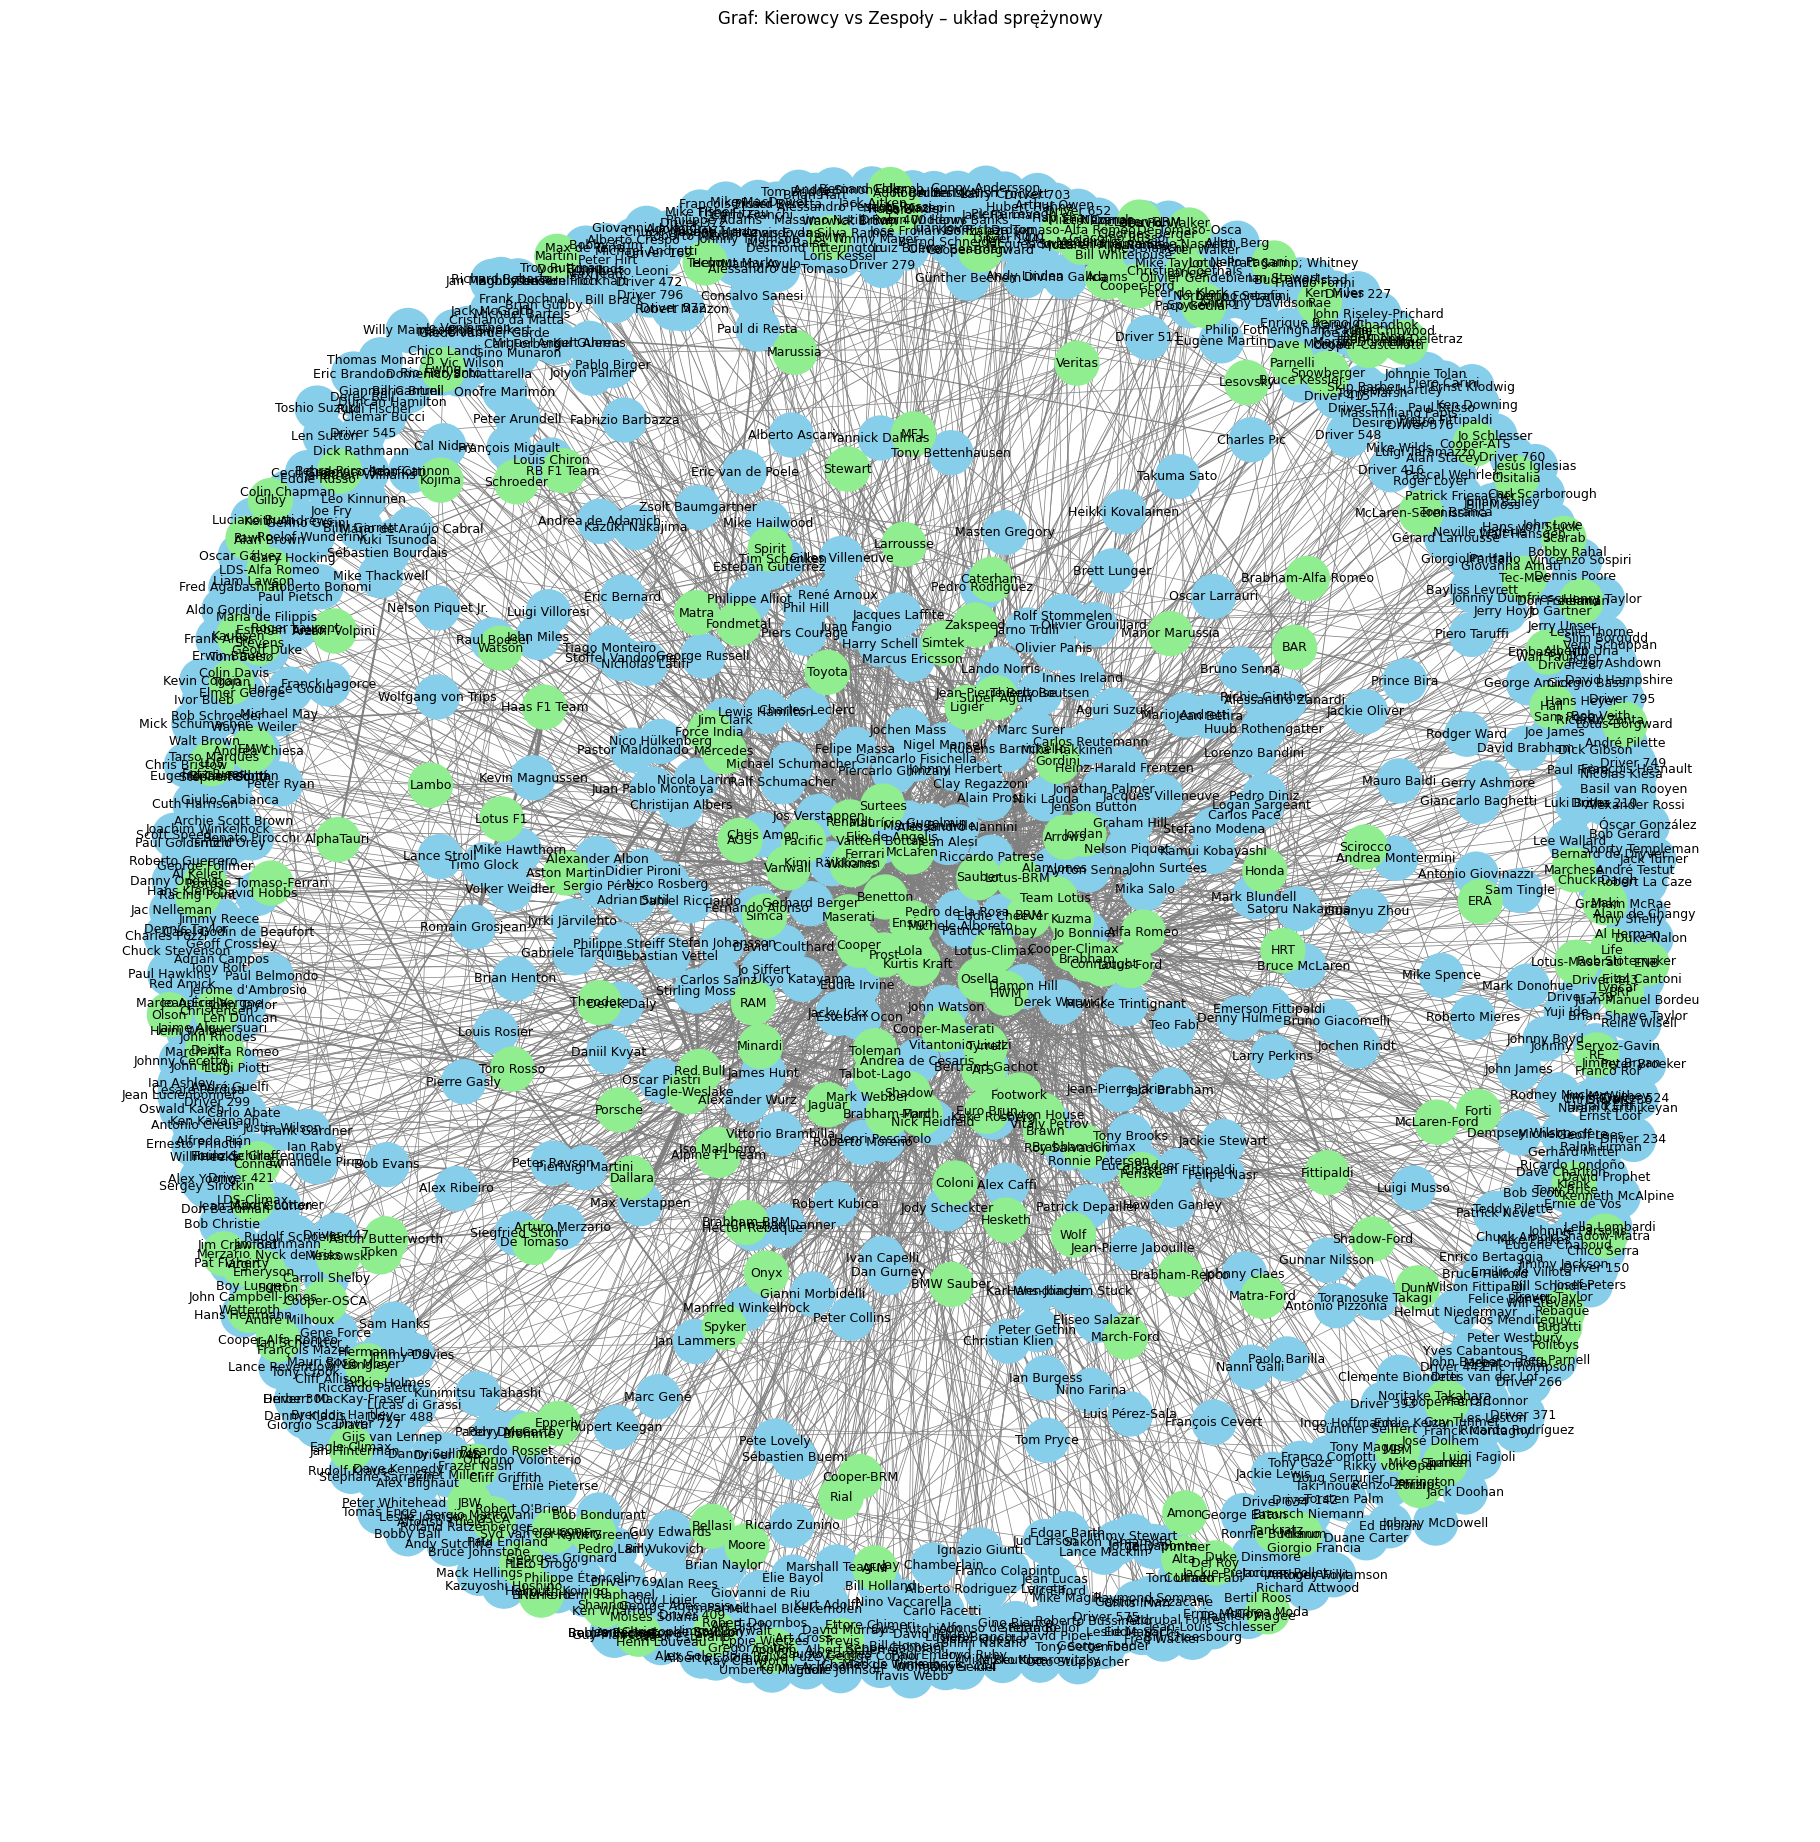

In [24]:
pos = nx.spring_layout(B, seed=1, k=0.9)  

weights = [d['weight'] for _, _, d in B.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = [0.5 + 4.0 * (w - min_w) / (max_w - min_w) for w in weights]

drivers_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
node_colors = ['skyblue' if n in drivers_nodes else 'lightgreen' for n in B.nodes()]

plt.figure(figsize=(18, 18))
nx.draw(
    B, pos,
    with_labels=True,
    labels=nx.get_node_attributes(B, 'label'),
    node_color=node_colors,
    edge_color='gray',
    width=edge_widths,
    node_size=1000,
    font_size=9
)
plt.title("Graf: Kierowcy vs Zespoły – układ sprężynowy")
plt.axis('off')
plt.tight_layout()
plt.show()

Wybranie tylko niektórych wierzchołków dla poszczególnych wag krawędzi.

In [18]:
min_weight = 30

/tmp/ipykernel_10958/3004812469.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


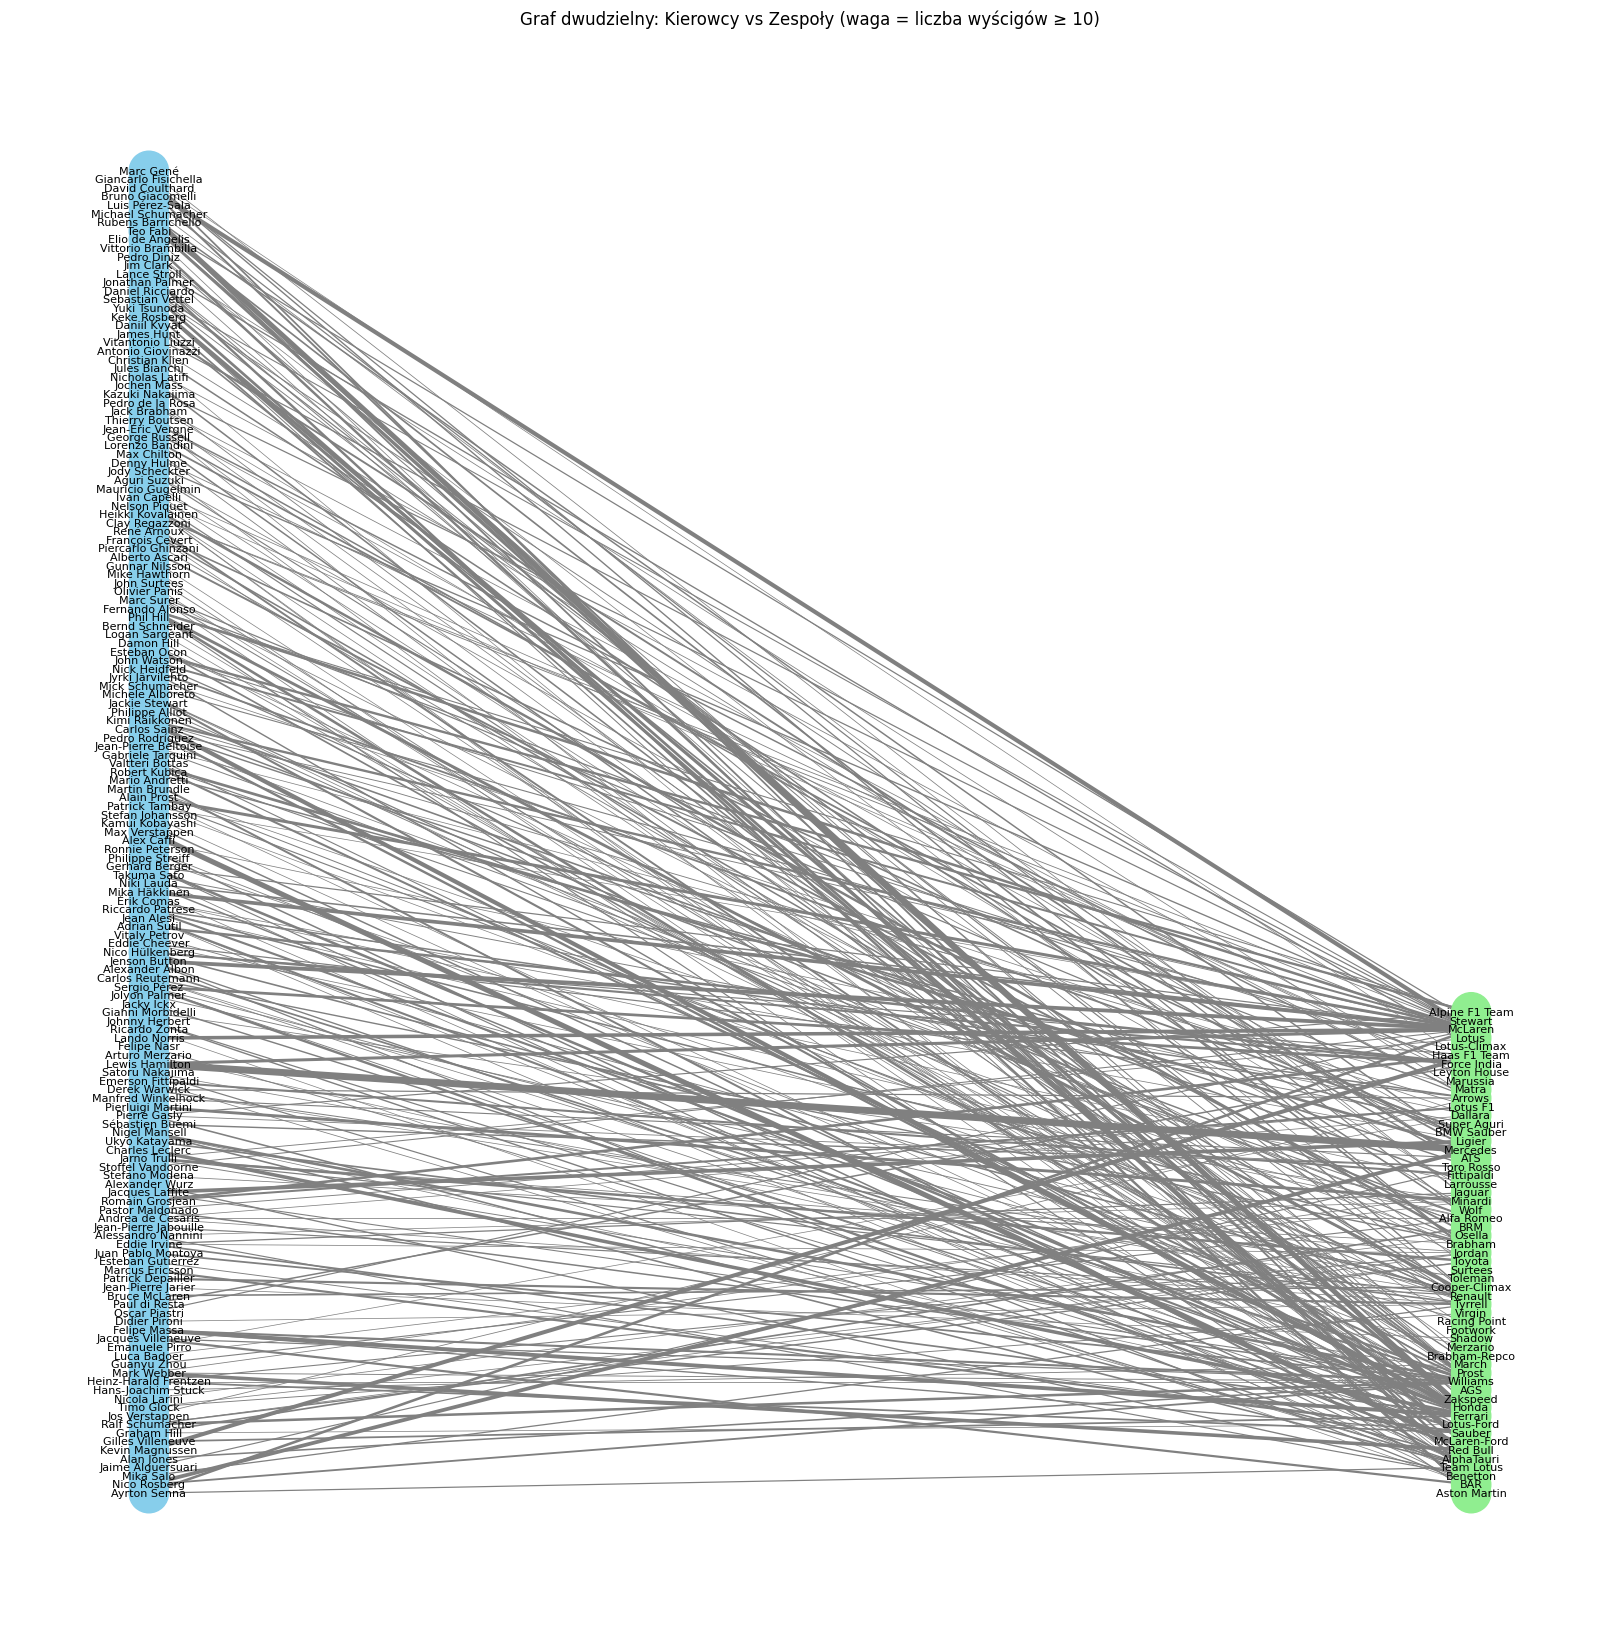

In [22]:

B_filtered = nx.Graph()
for u, v, d in B.edges(data=True):
    if d['weight'] >= min_weight:
        B_filtered.add_edge(u, v, **d)
        B_filtered.nodes[u].update(B.nodes[u])
        B_filtered.nodes[v].update(B.nodes[v])

drivers_nodes = {n for n, d in B_filtered.nodes(data=True) if d['bipartite'] == 0}
teams_nodes = set(B_filtered) - drivers_nodes

pos = dict()
pos.update((node, (1, i)) for i, node in enumerate(drivers_nodes))  # lewa kolumna
pos.update((node, (2, i)) for i, node in enumerate(teams_nodes))    # prawa kolumna

weights = [d['weight'] for _, _, d in B_filtered.edges(data=True)]
min_w = min(weights)
max_w = max(weights)

edge_weights = [
    0.5 + 4.5 * (w - min_w) / (max_w - min_w) for w in weights  #normalizacja
]

node_colors = ['skyblue' if n in drivers_nodes else 'lightgreen' for n in B_filtered.nodes()]

plt.figure(figsize=(16, 16))
nx.draw(
    B_filtered, pos,
    with_labels=True,
    labels=nx.get_node_attributes(B_filtered, 'label'),
    node_color=node_colors,
    edge_color='gray',
    width=edge_weights,
    node_size=800,
    font_size=8
)
plt.title("Graf dwudzielny: Kierowcy vs Zespoły (waga = liczba wyścigów ≥ 10)")
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_10958/265290059.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


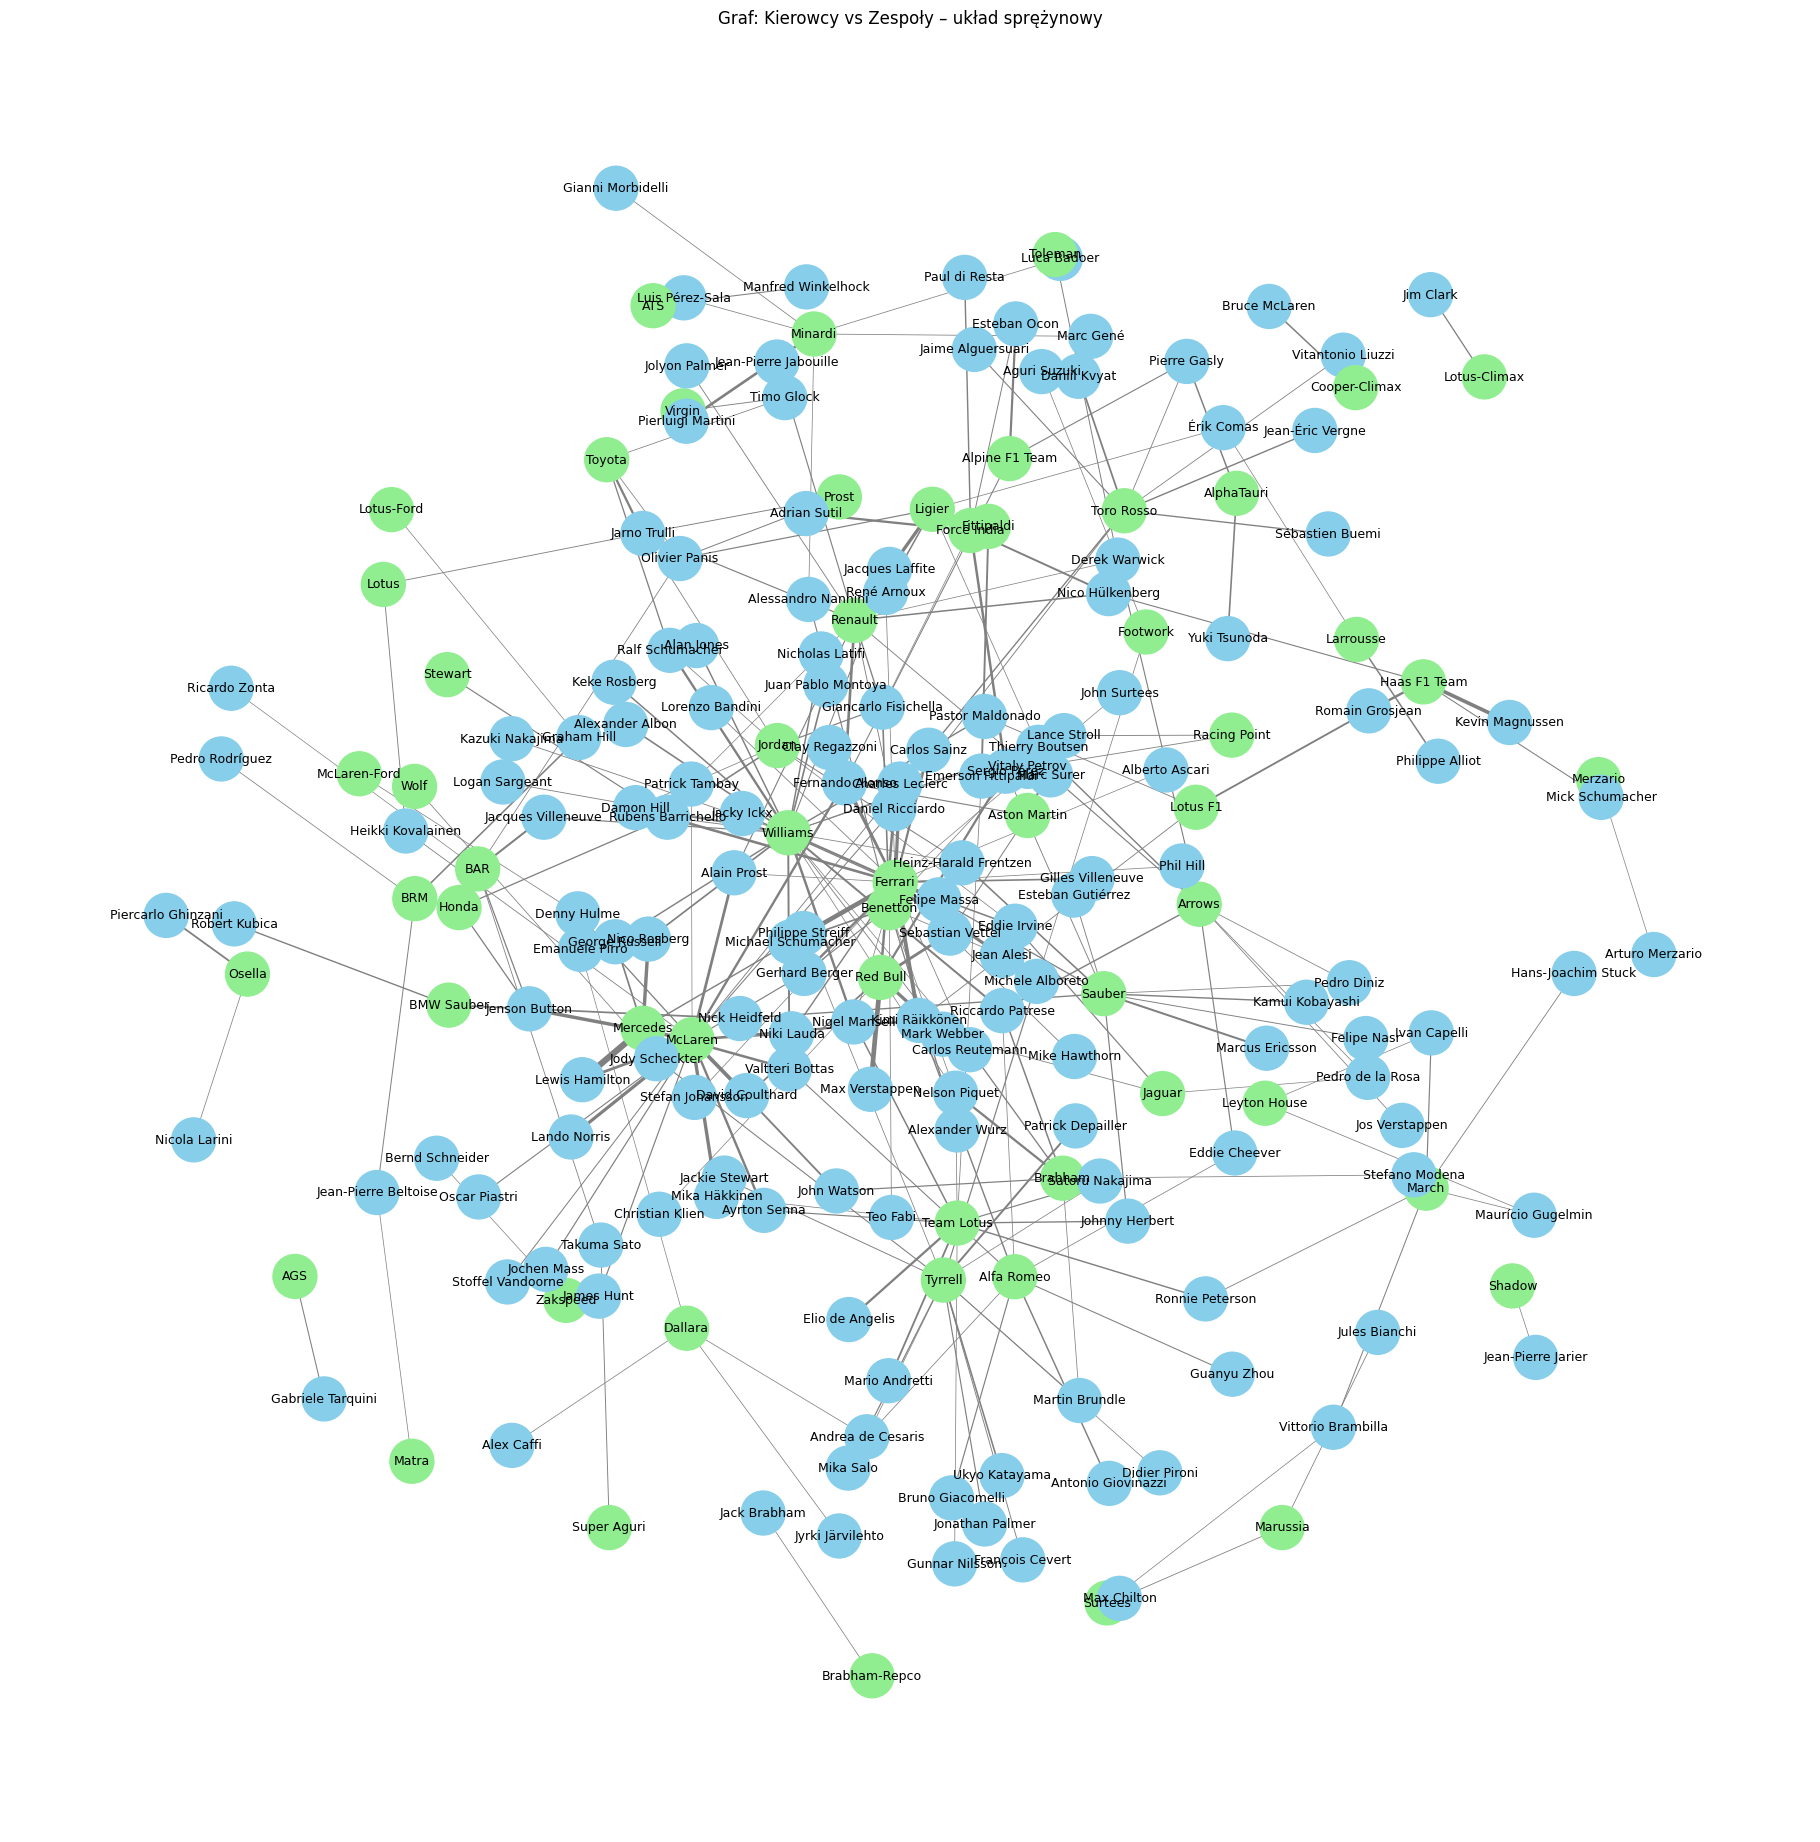

In [21]:
pos = nx.spring_layout(B_filtered, seed=1, k=0.9)  

weights = [d['weight'] for _, _, d in B_filtered.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = [0.5 + 4.0 * (w - min_w) / (max_w - min_w) for w in weights]

drivers_nodes = {n for n, d in B_filtered.nodes(data=True) if d['bipartite'] == 0}
node_colors = ['skyblue' if n in drivers_nodes else 'lightgreen' for n in B_filtered.nodes()]

plt.figure(figsize=(18, 18))
nx.draw(
    B_filtered, pos,
    with_labels=True,
    labels=nx.get_node_attributes(B_filtered, 'label'),
    node_color=node_colors,
    edge_color='gray',
    width=edge_widths,
    node_size=1000,
    font_size=9
)
plt.title("Graf: Kierowcy vs Zespoły – układ sprężynowy")
plt.axis('off')
plt.tight_layout()
plt.show()